In [48]:
###

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# load data
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [51]:
# Display the first few rows of the dataset
data_head = data.head()

# Get the shape of the dataset
data_shape = data.shape

data_head, data_shape


(       destination  passanger weather  temperature  time  \
 0  No Urgent Place      Alone   Sunny           55   2PM   
 1  No Urgent Place  Friend(s)   Sunny           80  10AM   
 2  No Urgent Place  Friend(s)   Sunny           80  10AM   
 3  No Urgent Place  Friend(s)   Sunny           80   2PM   
 4  No Urgent Place  Friend(s)   Sunny           80   2PM   
 
                   coupon expiration  gender age      maritalStatus  ...  \
 0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
 1           Coffee House         2h  Female  21  Unmarried partner  ...   
 2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
 3           Coffee House         2h  Female  21  Unmarried partner  ...   
 4           Coffee House         1d  Female  21  Unmarried partner  ...   
 
    CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
 0        never       NaN                  4~8              1~3   
 1        never       NaN               

In [52]:
# Basic statistics
data_description = data.describe(include='all')

data_description

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684,12684,12684,12684.000000,12684,12684,12684,12684,12684,12684,...,12467,12533,12554,12495,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
unique,3,4,3,NaN,5,5,2,2,8,5,...,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN
top,No Urgent Place,Alone,Sunny,NaN,6PM,Coffee House,1d,Female,21,Married partner,...,less1,1~3,1~3,less1,NaN,NaN,NaN,NaN,NaN,NaN
freq,6283,7305,10069,NaN,3230,3996,7091,6511,2653,5100,...,3385,4672,5376,6077,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,63.301798,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,NaN,NaN,NaN,19.154486,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,NaN,NaN,NaN,80.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.000000,0.000000,0.000000,1.000000,1.000000


<Axes: xlabel='Y', ylabel='count'>

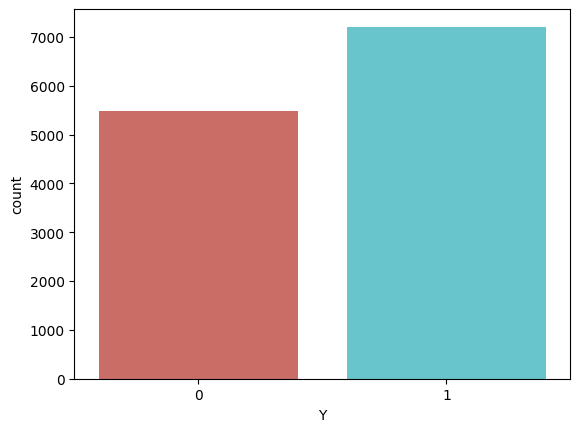

In [53]:
# Balance of the dataset
data['Y'].value_counts()

# graph
sns.countplot(x='Y', data=data, palette='hls')

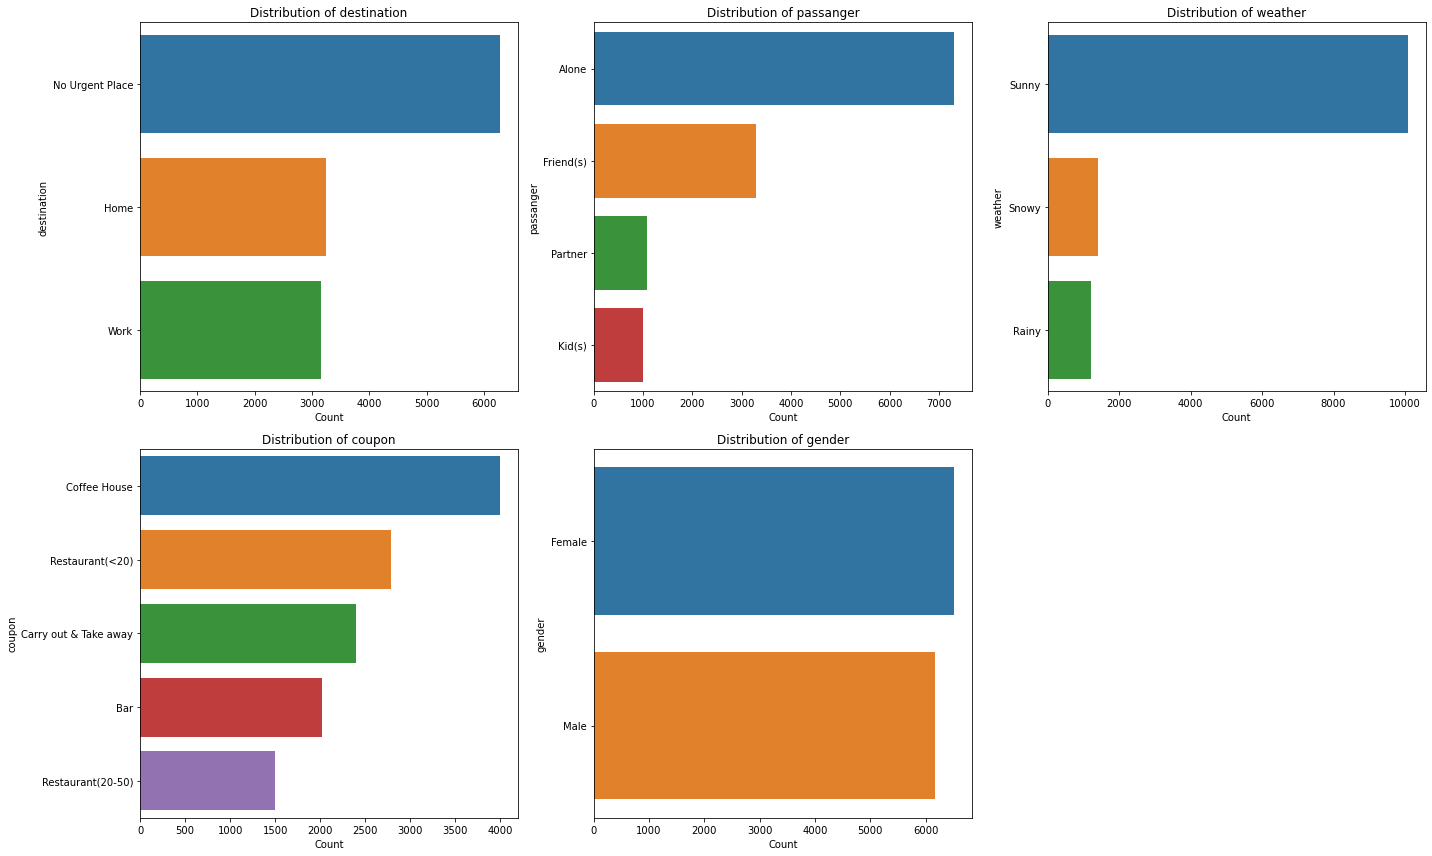

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
columns_to_visualize = ['destination', 'passanger', 'weather', 'coupon', 'gender']

plt.figure(figsize=(20, 12))

# Plotting the distribution of the selected columns
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=data, y=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()

plt.show()


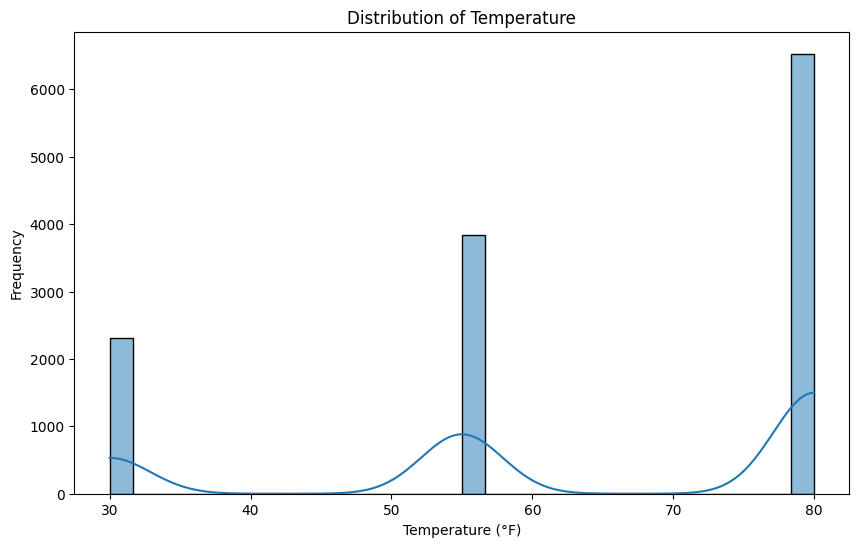

In [55]:
# Visualize the distribution of the 'temperature' column
plt.figure(figsize=(10, 6))
sns.histplot(data['temperature'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

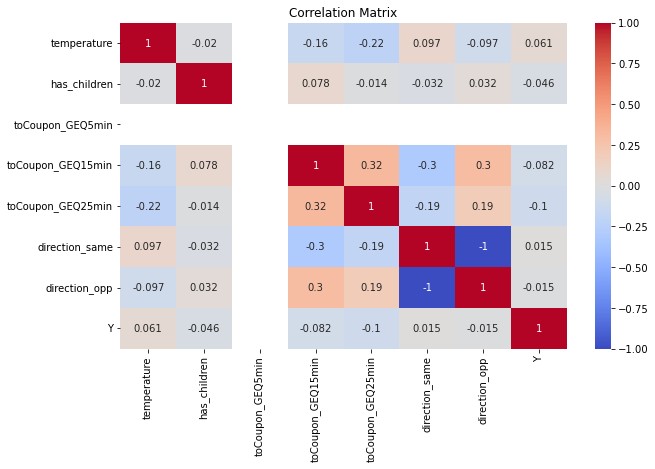

In [94]:
# List of numerical columns for correlation analysis

# Compute the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# Case 1: Imputation with the highest count

In [12]:
number_nans_car = data['car'].isna().sum()
number_nans_car/len(data['car'])

0.9914853358561968

As it is clear, the column 'car' has too many missing values, 99%, so we drop this column

In [15]:
data = data.drop('car', axis=1)

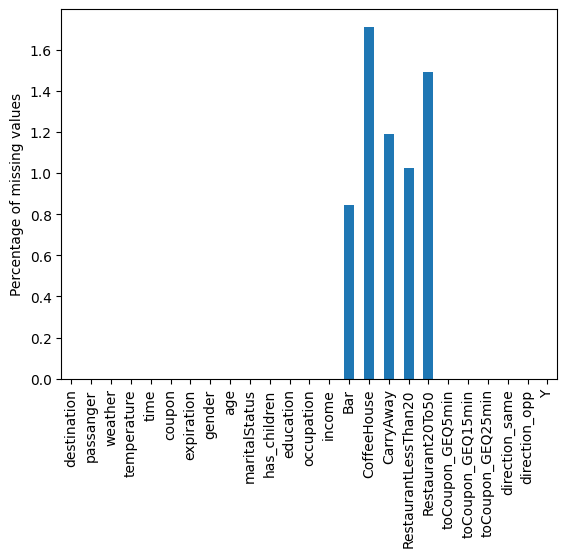

In [16]:
# calculate percentage of missing values for each column
missing_percentages = data.isna().mean() * 100

# create bar plot
missing_percentages.plot(kind='bar')
plt.ylabel('Percentage of missing values')
plt.show()

As can be observed, the percentage of missing values is relatively small, below 1.7%, so we can either drop the rows with missing values or impute them with the most frequent value. We will impute them with the most frequent value.

In [19]:
data = data.fillna(data.mode().iloc[0])

Let us now observe the importance of each feature from the data

In [20]:
X = data.drop("Y", axis=1)
y = data["Y"]

In [22]:
categorical_cols = X.select_dtypes(include=['object']).columns

categorical_cols

Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')

# Chi-Squared test to check for signicance association of each feature

In [23]:
from scipy.stats import chi2_contingency

# Dictionary to store p-values for each categorical column
p_values = {}

for col in categorical_cols:
    contingency_table = pd.crosstab(X[col], y)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    p_values[col] = p

# Filter columns with p-value less than 0.05 (indicating statistical significance)
significant_features = {k: v for k, v in p_values.items() if v < 0.05}

significant_features

{'destination': 8.40265678045787e-48,
 'passanger': 7.284119805592145e-48,
 'weather': 8.312207740720093e-31,
 'time': 8.37562170116935e-37,
 'coupon': 8.575341747082738e-188,
 'expiration': 2.2875426931245946e-48,
 'gender': 8.05552865589407e-07,
 'age': 3.5221422366296096e-11,
 'maritalStatus': 6.489647983232487e-10,
 'education': 6.858463266342188e-08,
 'occupation': 1.0136827151270322e-14,
 'income': 4.30446851198096e-08,
 'Bar': 3.133234600310471e-16,
 'CoffeeHouse': 4.171544970829023e-59,
 'CarryAway': 6.808987792859354e-09,
 'RestaurantLessThan20': 0.00010979372427199479,
 'Restaurant20To50': 9.005798285828938e-14}

Note that all p-values are smaller than 0.5, so we can conclude that all features are important for the model.

# Outliers e Fit distr.

### Outliers - Categorical


Text(0.5, 1.0, 'Frequency of Age')

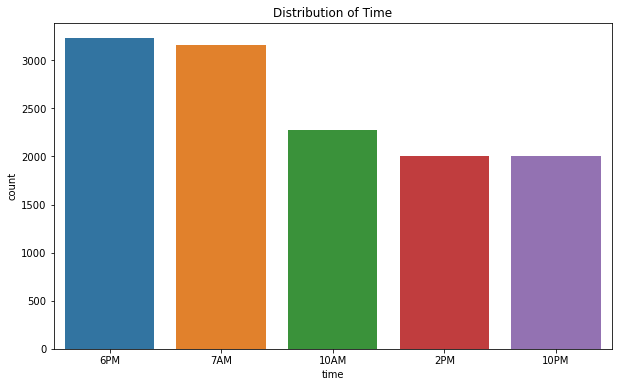

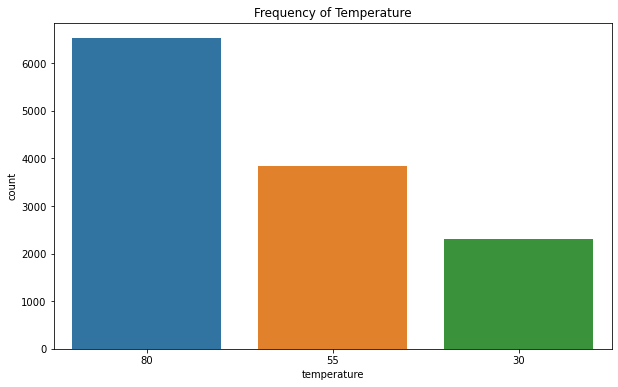

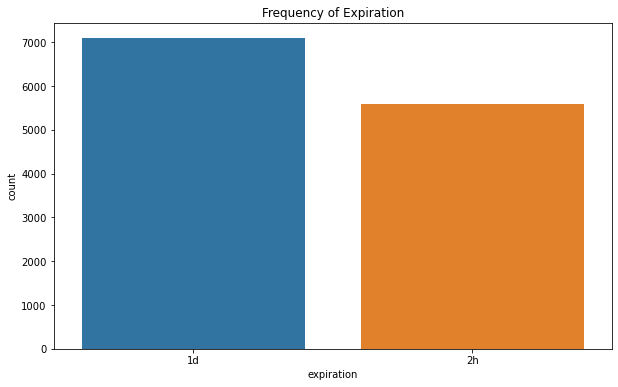

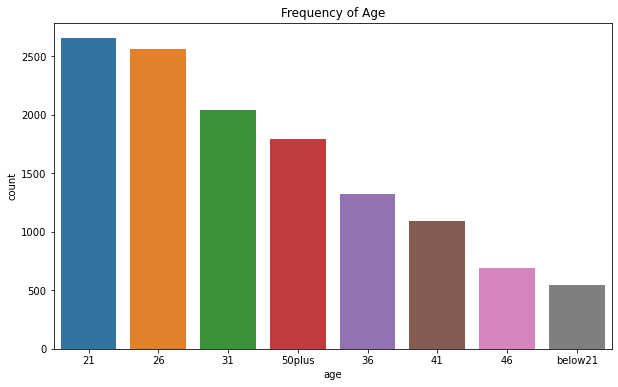

In [57]:
# Diferent categories in time column
data['time'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='time', order=data['time'].value_counts().index)
plt.title('Distribution of Time')

# Frequency of temperature
data['temperature'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='temperature', order=data['temperature'].value_counts().index)
plt.title('Frequency of Temperature')

# Same for expiration
data['expiration'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='expiration', order=data['expiration'].value_counts().index)
plt.title('Frequency of Expiration')

# Same for age
data['age'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='age', order=data['age'].value_counts().index)
plt.title('Frequency of Age')

In [58]:
# Data types of the columns
data.dtypes


destination             object
passanger               object
weather                 object
temperature              int64
time                    object
coupon                  object
expiration              object
gender                  object
age                     object
maritalStatus           object
has_children             int64
education               object
occupation              object
income                  object
car                     object
Bar                     object
CoffeeHouse             object
CarryAway               object
RestaurantLessThan20    object
Restaurant20To50        object
toCoupon_GEQ5min         int64
toCoupon_GEQ15min        int64
toCoupon_GEQ25min        int64
direction_same           int64
direction_opp            int64
Y                        int64
dtype: object

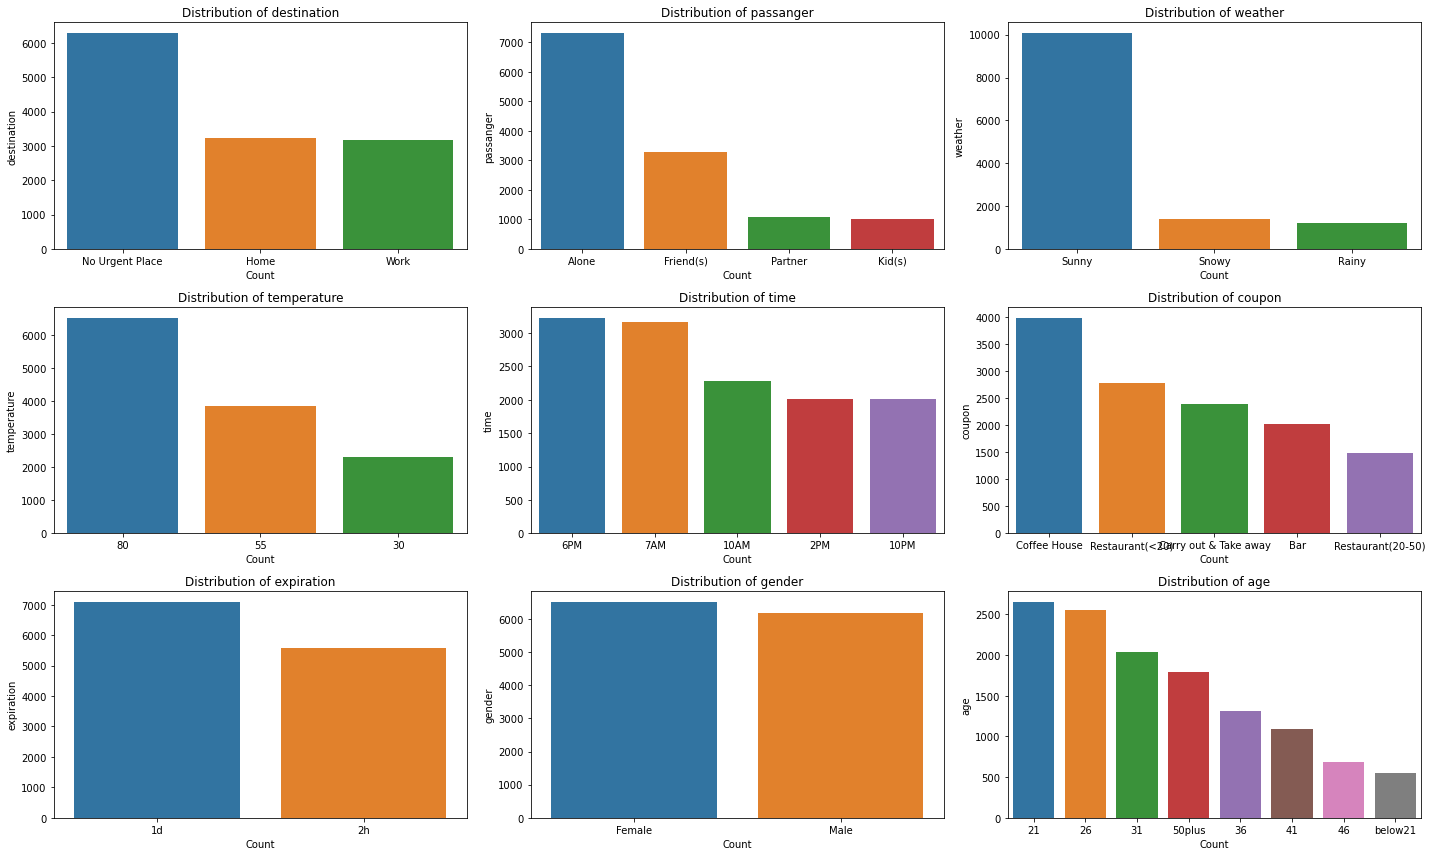

In [59]:
# Frequency and plots for all columns. Plots in one image
plt.figure(figsize=(20, 12))

# Plotting the distribution of the selected columns
for i, column in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=data, x=column, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    # layout bigger on y axis
    plt.tight_layout()
    if i == 9:
        break

plt.show()

In [60]:
# frequency of occupation
data['occupation'].value_counts()


Unemployed                                   1870
Student                                      1584
Computer & Mathematical                      1408
Sales & Related                              1093
Education&Training&Library                    943
Management                                    838
Office & Administrative Support               639
Arts Design Entertainment Sports & Media      629
Business & Financial                          544
Retired                                       495
Food Preparation & Serving Related            298
Healthcare Practitioners & Technical          244
Healthcare Support                            242
Community & Social Services                   241
Legal                                         219
Transportation & Material Moving              218
Architecture & Engineering                    175
Personal Care & Service                       175
Protective Service                            175
Life Physical Social Science                  170


In [61]:
# Frequency analysis for each categorical variable
potential_outliers = {}

for column in data.columns:
    # Count the occurrences of each category in the column
    value_counts = data[column].value_counts(normalize=True)
    
    # Consider categories with less than a certain threshold (e.g., 1% for this example) as potential outliers
    outliers = value_counts[value_counts < 0.02].index.tolist()
    
    if outliers:
        potential_outliers[column] = outliers

potential_outliers

{'maritalStatus': ['Widowed'],
 'education': ['Some High School'],
 'occupation': ['Healthcare Practitioners & Technical',
  'Healthcare Support',
  'Community & Social Services',
  'Legal',
  'Transportation & Material Moving',
  'Architecture & Engineering',
  'Personal Care & Service',
  'Protective Service',
  'Life Physical Social Science',
  'Construction & Extraction',
  'Installation Maintenance & Repair',
  'Production Occupations',
  'Building & Grounds Cleaning & Maintenance',
  'Farming Fishing & Forestry'],
 'CarryAway': ['never'],
 'RestaurantLessThan20': ['never']}

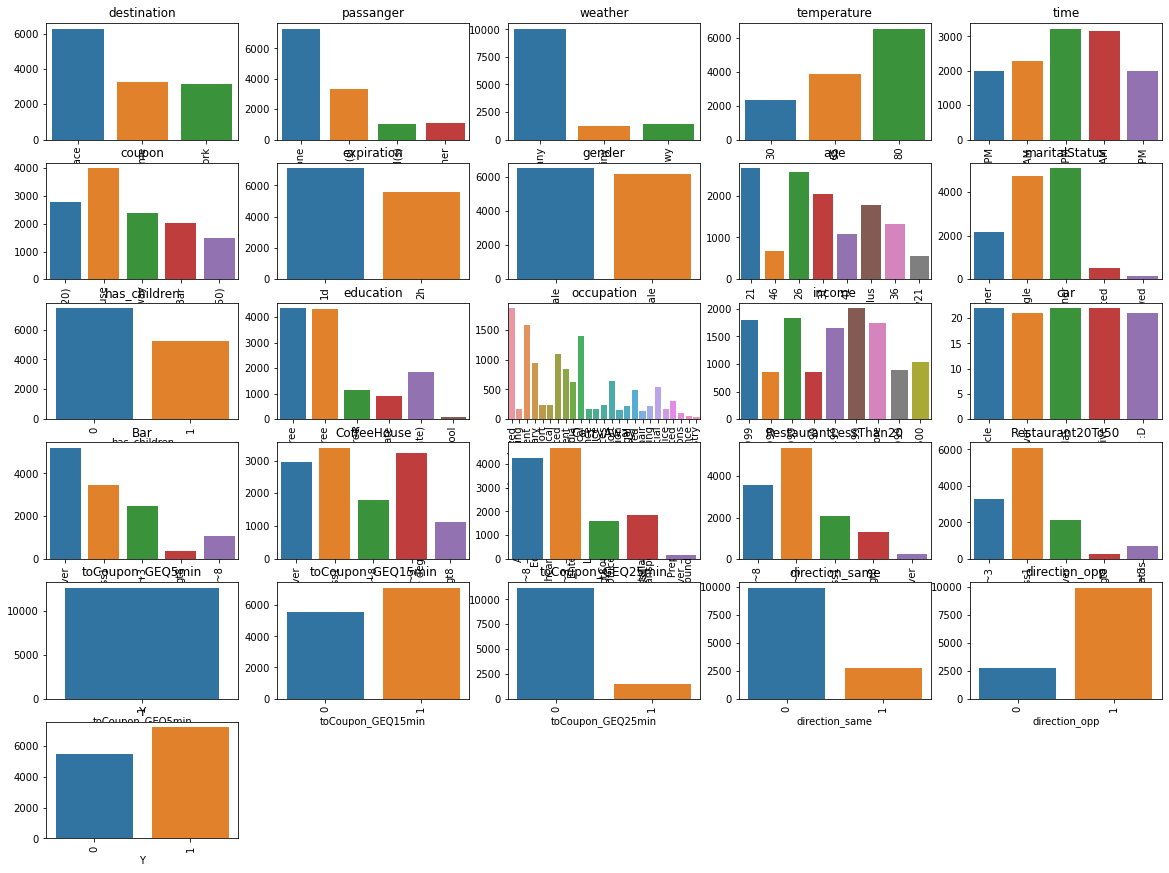

In [62]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Bar Plots
plt.figure(figsize=(20, 15))
for i, column in enumerate(data.columns, 1):
    plt.subplot(6, 5, i)
    sns.countplot(data[column])
    plt.xticks(rotation=90)
    plt.ylabel("")
    plt.title(column)

plt.tight_layout()
plt.show()

In [63]:
# One class svm

from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# One-hot encode the data
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data)

# One-Class SVM
oc_svm = OneClassSVM(nu=0.05, kernel="rbf")
oc_svm_labels = oc_svm.fit_predict(data_encoded)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.05)
iso_forest_labels = iso_forest.fit_predict(data_encoded)

# Convert labels from (-1,1) to (0,1) for consistency
oc_svm_labels = (oc_svm_labels + 1) // 2
iso_forest_labels = (iso_forest_labels + 1) // 2

oc_svm_labels, iso_forest_labels

# count outliers for each model
oc_svm_outliers = sum(oc_svm_labels == 0)
iso_forest_outliers = sum(iso_forest_labels == 0)

oc_svm_outliers, iso_forest_outliers

(639, 635)

In [64]:
import matplotlib.pyplot as plt

# Plotting the results of One-Class SVM with values within 

### K-modes

In [65]:
# import data
data2 = pd.read_csv('in-vehicle-coupon-recommendation.csv')

### DBSCAN

### Balance


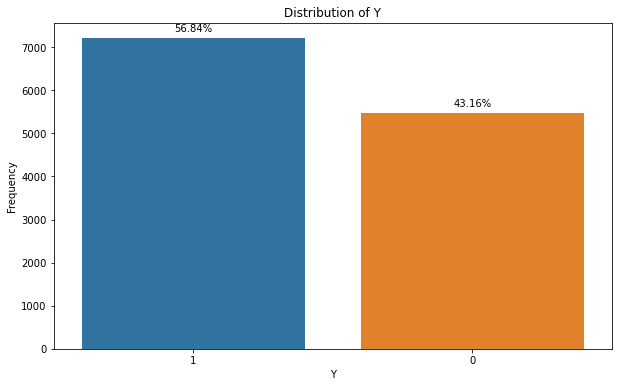

In [93]:
# Specify the order for countplot based on the index of percentage (which comes from value_counts)
order = percentage.index

# Plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=data['Y'], order=order)
plt.title('Distribution of Y')
plt.xlabel('Y')
plt.ylabel('Frequency')

# Add percentage text on top of each bar
for p, value in zip(ax.patches, percentage):
    ax.annotate(f'{value:.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


